In [3]:
import pandas as pd
import numpy as np

block_df = pd.read_csv('../data/Census_Block_Groups_20250419.csv')
crime_df = pd.read_csv('../data/Crime_Reports_20250419.csv')  # Replace with your actual file path
crime_df = crime_df.dropna(subset=['Census Block Group']).copy()

# Display basic info
print(f"Data shape: {block_df.shape}")
block_df.head()

Data shape: (1219, 17)


ALAND  AWATER  Census Block Group  BLKGRPCE  County FIPS code  FID  \
0  16568824  653590          4530329001         1               453  633   
1   2893460       0          4530343001         1               453  632   
2    937294       0          4530023233         3               453  631   
3    435392       0          4530014013         3               453  630   
4    955624       0          4530304002         2               453  629   

  FUNCSTAT        Geo ID   INTPTLAT   INTPTLON  MTFCC       NAMELSAD  \
0        S  484530329001  30.351493 -97.819706  G5030  Block Group 1   
1        S  484530343001  30.433492 -97.809637  G5030  Block Group 1   
2        S  484530023233  30.229687 -97.752703  G5030  Block Group 3   
3        S  484530014013  30.251845 -97.745337  G5030  Block Group 3   
4        S  484530304002  30.208642 -97.800775  G5030  Block Group 2   

   State FIPS code   Shape__Area  Shape__Length  TRACTCE  \
0               48  1.853594e+08   71940.666646    32900   
1               48  3.114045e+07   38887.374275    34300   
2               48  1.008835e+07   15534.017276     2323   
3               48  4.686182e+06    9303.520895     1401   
4               48  1.028572e+07   13864.390453    30400   

                                             polygon  
0  POLYGON ((-97.851652656748 30.3521162279844, -...  
1  POLYGON ((-97.8187456533663 30.4430782467377, ...  
2  POLYGON ((-97.7598106284108 30.2303352073011, ...  
3  POLYGON ((-97.7491126269989 30.2511212123879, ...  
4  POLYGON ((-97.8069046390813 30.2029922009659, ...

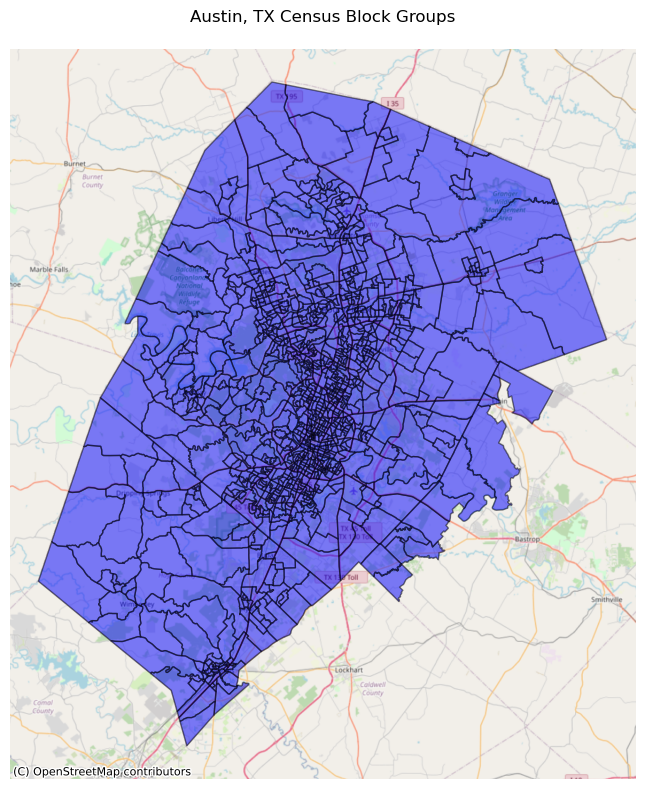

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import contextily as ctx

# 1. Convert your polygon string to a GeoDataFrame
# Assuming your data is in a DataFrame called 'df' with a 'polygon' column
block_df['geometry'] = block_df['polygon'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(block_df, geometry='geometry', crs="EPSG:4326")  # WGS84 coordinate system
gdf_polygons = gdf
# 2. Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the polygon
gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# Add map context (optional)
import contextily as ctx
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Format the plot
ax.set_title('Austin, TX Census Block Groups', pad=20)
ax.set_axis_off()  # Hide lat/lon axes
plt.tight_layout()
plt.show()

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np


# 2. Get crime counts per Census Block Group from your crime data
crime_counts = crime_df['Census Block Group'].value_counts().reset_index()
crime_counts.columns = ['Census Block Group', 'Crime Count']

crime_counts.head()

Census Block Group  Crime Count
0        4.530011e+09        84427
1        4.530011e+09        34882
2        4.530009e+09        27871
3        4.530023e+09        22543
4        4.530021e+09        19710

In [6]:
# 3. Merge crime data with polygons
gdf_merged = gdf_polygons.merge(crime_counts, 
                              on='Census Block Group',
                              how='left').fillna(0)  # Fill NA with 0 crimes
gdf_merged.head()

ALAND  AWATER  Census Block Group  BLKGRPCE  County FIPS code  FID  \
0  16568824  653590          4530329001         1               453  633   
1   2893460       0          4530343001         1               453  632   
2    937294       0          4530023233         3               453  631   
3    435392       0          4530014013         3               453  630   
4    955624       0          4530304002         2               453  629   

  FUNCSTAT        Geo ID   INTPTLAT   INTPTLON  MTFCC       NAMELSAD  \
0        S  484530329001  30.351493 -97.819706  G5030  Block Group 1   
1        S  484530343001  30.433492 -97.809637  G5030  Block Group 1   
2        S  484530023233  30.229687 -97.752703  G5030  Block Group 3   
3        S  484530014013  30.251845 -97.745337  G5030  Block Group 3   
4        S  484530304002  30.208642 -97.800775  G5030  Block Group 2   

   State FIPS code   Shape__Area  Shape__Length  TRACTCE  \
0               48  1.853594e+08   71940.666646    32900   
1               48  3.114045e+07   38887.374275    34300   
2               48  1.008835e+07   15534.017276     2323   
3               48  4.686182e+06    9303.520895     1401   
4               48  1.028572e+07   13864.390453    30400   

                                             polygon  \
0  POLYGON ((-97.851652656748 30.3521162279844, -...   
1  POLYGON ((-97.8187456533663 30.4430782467377, ...   
2  POLYGON ((-97.7598106284108 30.2303352073011, ...   
3  POLYGON ((-97.7491126269989 30.2511212123879, ...   
4  POLYGON ((-97.8069046390813 30.2029922009659, ...   

                                            geometry  Crime Count  
0  POLYGON ((-97.85165 30.35212, -97.85105 30.352...       1984.0  
1  POLYGON ((-97.81875 30.44308, -97.81852 30.443...       1304.0  
2  POLYGON ((-97.75981 30.23034, -97.75951 30.230...       2631.0  
3  POLYGON ((-97.74911 30.25112, -97.74871 30.252...       3151.0  
4  POLYGON ((-97.8069 30.20299, -97.80666 30.2043...       1397.0

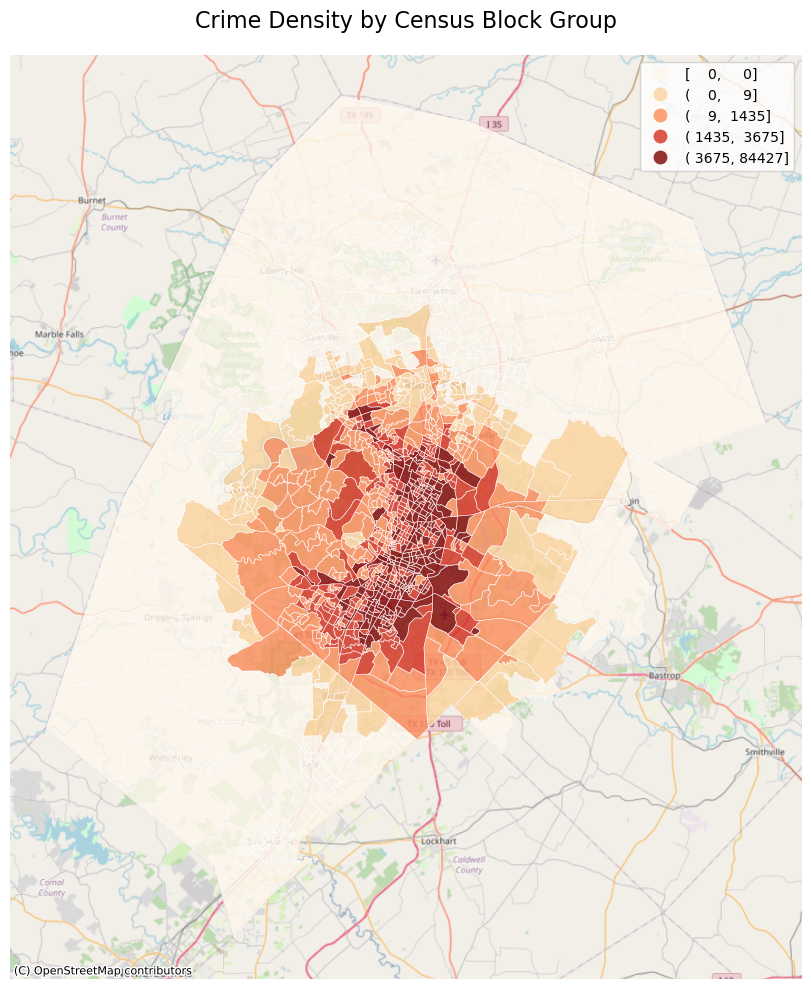

In [7]:
# 4. Create the choropleth map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot using quantile classification for color bins
gdf_merged.plot(column='Crime Count',
               ax=ax,
               legend=True,
               scheme='quantiles',
               k=5,  # Keep original 5 bins
               cmap='OrRd',  # Keep original color scale
               edgecolor='white',
               linewidth=0.5,
               alpha=0.8,
               legend_kwds={
                   'fmt': "{:.0f}",  # Format numbers as integers
                   'interval': True  # Key change: makes legend continuous
               })

# Add basemap
ctx.add_basemap(ax, crs=gdf_merged.crs.to_string(), 
               source=ctx.providers.OpenStreetMap.Mapnik)

# Formatting
ax.set_title('Crime Density by Census Block Group', fontsize=16, pad=20)
ax.set_axis_off()
plt.tight_layout()

plt.show()

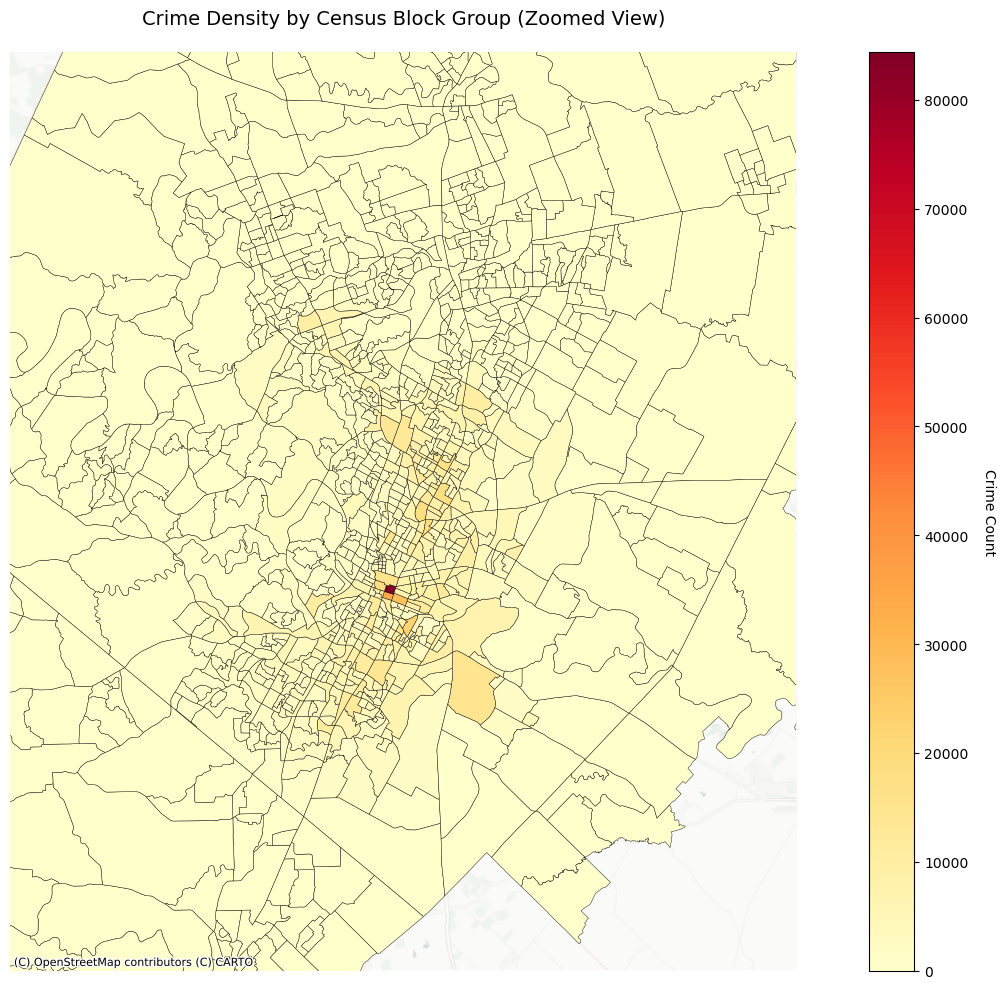

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# 2. Set up the plot with zoomed-in extent
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate zoomed bounds (using middle 50% of data by default)
xmin, ymin, xmax, ymax = gdf_merged.geometry.total_bounds
dx, dy = (xmax-xmin)*0.20, (ymax-ymin)*0.20  # Changed from 0.25 to 0.20
ax.set_xlim(xmin+dx, xmax-dx)
ax.set_ylim(ymin+dy, ymax-dy)

# 3. Create the choropleth plot
plot = gdf_merged.plot(
    column='Crime Count',
    ax=ax,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    edgecolor='black',
    linewidth=0.3,
    legend=False  # We'll add a proper scale bar
)

# 4. Add professional scale bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Create colorbar with scientific notation if needed
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=plt.Normalize(
        vmin=gdf_merged['Crime Count'].min(), 
        vmax=gdf_merged['Crime Count'].max()
    )
)
fig.colorbar(sm, cax=cax).set_label('Crime Count', rotation=270, labelpad=20)

# 5. Add basemap and final touches
ctx.add_basemap(ax, crs=gdf_merged.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title('Crime Density by Census Block Group (Zoomed View)', fontsize=14, pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()

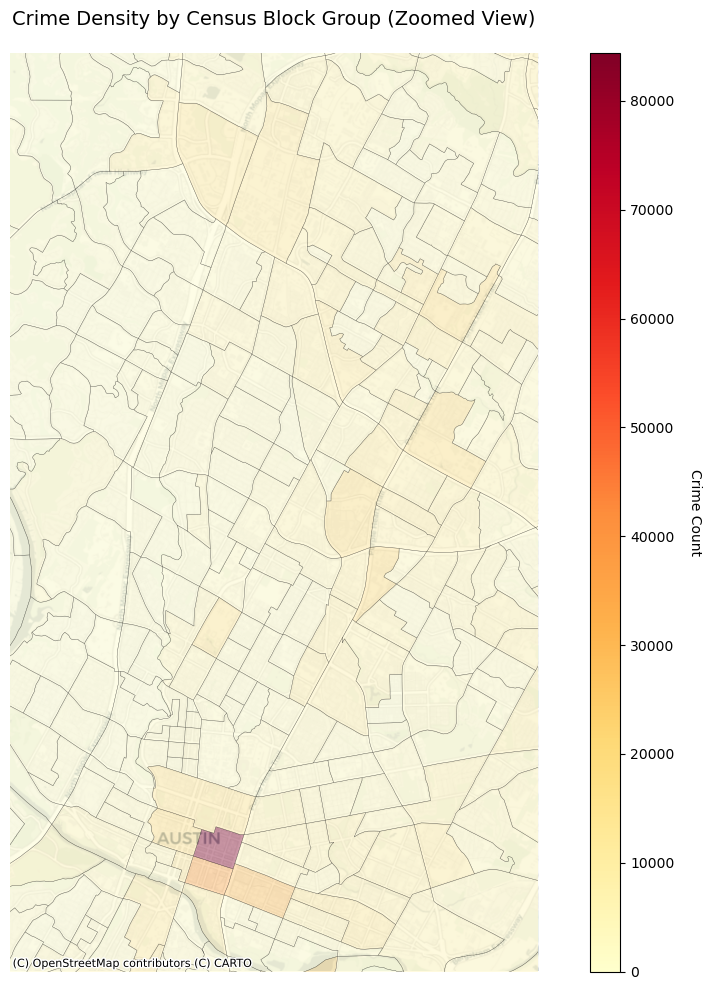

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# 2. Set up the plot with zoomed-in extent
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate zoomed bounds (using middle 50% of data by default)
xmin, ymin, xmax, ymax = gdf_merged.geometry.total_bounds
dx, dy = (xmax-xmin)*0.453, (ymax-ymin)*0.43  # Changed from 0.25 to 0.20
ax.set_xlim(xmin+dx, xmax-dx)
ax.set_ylim(ymin+dy, ymax-dy)

# 3. Create the choropleth plot (modified for translucency)
plot = gdf_merged.plot(
    column='Crime Count',
    ax=ax,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    edgecolor='black',
    linewidth=0.3,
    legend=False,  # We'll add a proper scale bar
    alpha=0.4  # Key change: makes polygons 50% transparent
)

# 4. Add professional scale bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Create colorbar with scientific notation if needed
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=plt.Normalize(
        vmin=gdf_merged['Crime Count'].min(), 
        vmax=gdf_merged['Crime Count'].max()
    )
)
fig.colorbar(sm, cax=cax).set_label('Crime Count', rotation=270, labelpad=20)

# 5. Add basemap and final touches
ctx.add_basemap(ax, crs=gdf_merged.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title('Crime Density by Census Block Group (Zoomed View)', fontsize=14, pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.show()

## Post-Processing

### Random Forest Data

In [11]:
import pandas as pd

results_df = pd.read_csv('../results/crime_rf_predictions.csv')
results_df.head()

Census Block Group         Top1_Offense  Top1_Probability  \
0        4.530341e+09   FAMILY DISTURBANCE             0.297   
1        4.530024e+09                THEFT             0.418   
2        4.530011e+09                THEFT             0.513   
3        4.530011e+09  PUBLIC INTOXICATION             0.197   
4        4.530325e+09                  DWI             0.350   

                  Top2_Offense  Top2_Probability  \
0                   HARASSMENT             0.133   
1       BURGLARY NON RESIDENCE             0.190   
2          ASSAULT WITH INJURY             0.217   
3                          DWI             0.121   
4  CUSTODY ARREST TRAFFIC WARR             0.144   

                     Top3_Offense  Top3_Probability  
0  ASSAULT W/INJURY-FAM/DATE VIOL             0.107  
1               CRIMINAL MISCHIEF             0.084  
2             PUBLIC INTOXICATION             0.085  
3             BURGLARY OF VEHICLE             0.108  
4             PUBLIC INTOXICATION             0.076

In [14]:
# 1. Merge predictions with your original polygon data
gdf_results = gdf_polygons.merge(
    results_df[['Census Block Group', 'Top1_Offense']],
    on='Census Block Group'
)
gdf_results.head()

ALAND  AWATER  Census Block Group  BLKGRPCE  County FIPS code  FID  \
0  16568824  653590          4530329001         1               453  633   
1   2893460       0          4530343001         1               453  632   
2    937294       0          4530023233         3               453  631   
3    435392       0          4530014013         3               453  630   
4    955624       0          4530304002         2               453  629   

  FUNCSTAT        Geo ID   INTPTLAT   INTPTLON  MTFCC       NAMELSAD  \
0        S  484530329001  30.351493 -97.819706  G5030  Block Group 1   
1        S  484530343001  30.433492 -97.809637  G5030  Block Group 1   
2        S  484530023233  30.229687 -97.752703  G5030  Block Group 3   
3        S  484530014013  30.251845 -97.745337  G5030  Block Group 3   
4        S  484530304002  30.208642 -97.800775  G5030  Block Group 2   

   State FIPS code   Shape__Area  Shape__Length  TRACTCE  \
0               48  1.853594e+08   71940.666646    32900   
1               48  3.114045e+07   38887.374275    34300   
2               48  1.008835e+07   15534.017276     2323   
3               48  4.686182e+06    9303.520895     1401   
4               48  1.028572e+07   13864.390453    30400   

                                             polygon  \
0  POLYGON ((-97.851652656748 30.3521162279844, -...   
1  POLYGON ((-97.8187456533663 30.4430782467377, ...   
2  POLYGON ((-97.7598106284108 30.2303352073011, ...   
3  POLYGON ((-97.7491126269989 30.2511212123879, ...   
4  POLYGON ((-97.8069046390813 30.2029922009659, ...   

                                            geometry        Top1_Offense  
0  POLYGON ((-97.85165 30.35212, -97.85105 30.352...               THEFT  
1  POLYGON ((-97.81875 30.44308, -97.81852 30.443...   CRIMINAL MISCHIEF  
2  POLYGON ((-97.75981 30.23034, -97.75951 30.230...  FAMILY DISTURBANCE  
3  POLYGON ((-97.74911 30.25112, -97.74871 30.252...                 DWI  
4  POLYGON ((-97.8069 30.20299, -97.80666 30.2043...  FAMILY DISTURBANCE

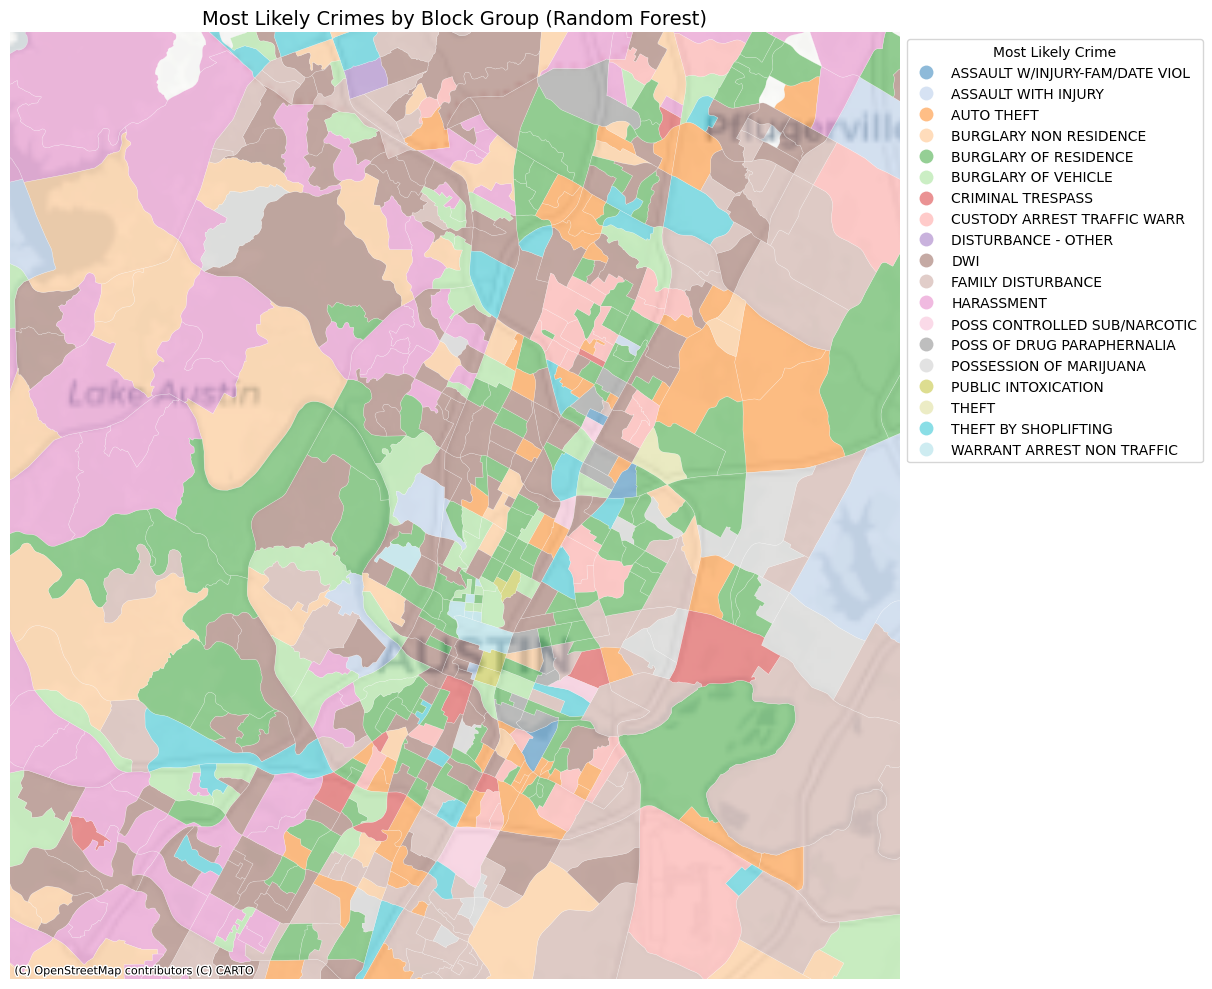

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 2. Create the map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot with categorical colors by top offense
gdf_results.plot(
    column='Top1_Offense',
    ax=ax,
    categorical=True,
    legend=True,
    cmap='tab20',  # Good for 20 categories
    edgecolor='white',
    linewidth=0.3,
    alpha=0.5,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'title': 'Most Likely Crime'
    }
)

# Add basemap
ctx.add_basemap(ax, crs=gdf_results.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set zoom (method 1 or 2 above)
xmin, ymin, xmax, ymax = gdf_results.total_bounds
padding_frac = 0.25  
dx, dy = (xmax-xmin)*padding_frac, (ymax-ymin)*padding_frac
ax.set_xlim(xmin + dx, xmax - dx)
ax.set_ylim(ymin + dy, ymax - dy)

# Final formatting
ax.set_title('Most Likely Crimes by Block Group (Random Forest)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Light GBM Model

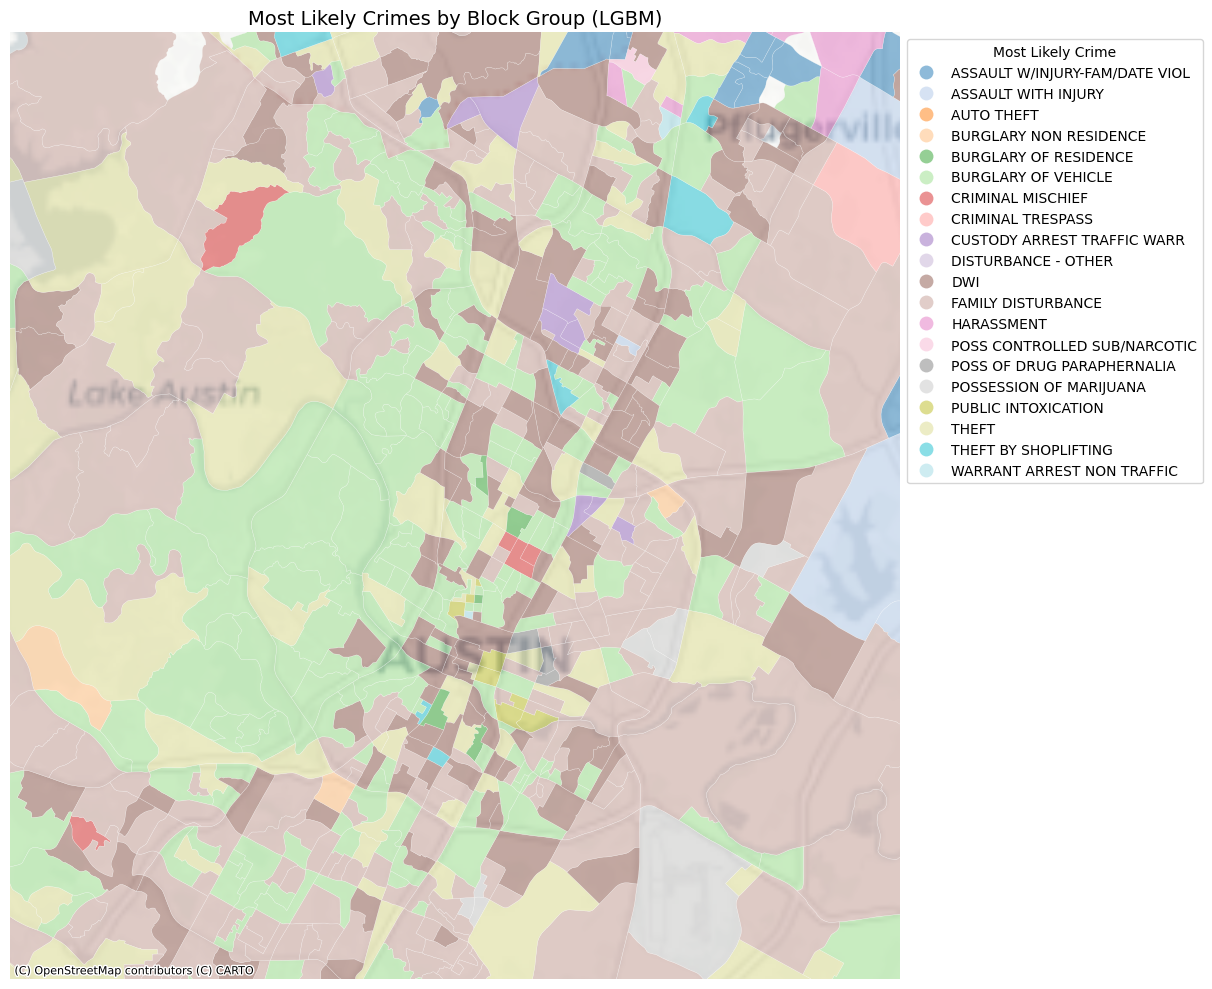

In [27]:
import pandas as pd

results_df = pd.read_csv('../results/crime_lgbm_predictions.csv')
results_df.head()

# 1. Merge predictions with your original polygon data
gdf_results = gdf_polygons.merge(
    results_df[['Census Block Group', 'Top1_Offense']],
    on='Census Block Group'
)
gdf_results.head()

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 2. Create the map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot with categorical colors by top offense
gdf_results.plot(
    column='Top1_Offense',
    ax=ax,
    categorical=True,
    legend=True,
    cmap='tab20',  # Good for 20 categories
    edgecolor='white',
    linewidth=0.3,
    alpha=0.5,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'title': 'Most Likely Crime'
    }
)

# Add basemap
ctx.add_basemap(ax, crs=gdf_results.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set zoom (method 1 or 2 above)
xmin, ymin, xmax, ymax = gdf_results.total_bounds
padding_frac = 0.25  
dx, dy = (xmax-xmin)*padding_frac, (ymax-ymin)*padding_frac
ax.set_xlim(xmin + dx, xmax - dx)
ax.set_ylim(ymin + dy, ymax - dy)

# Final formatting
ax.set_title('Most Likely Crimes by Block Group (LGBM)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### XG Boost


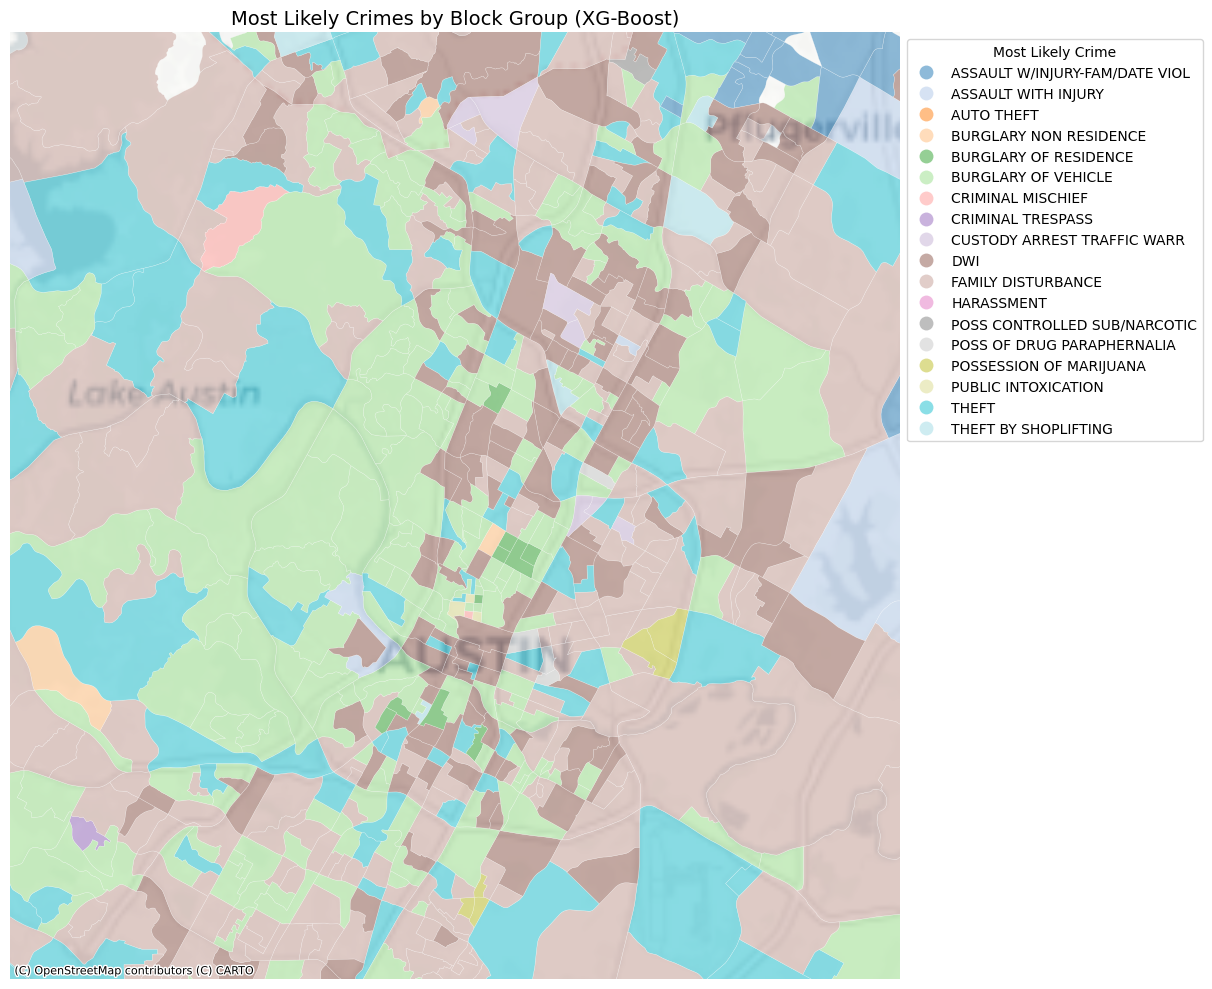

In [28]:
import pandas as pd

results_df = pd.read_csv('../results/crime_xgboost_predictions.csv')
results_df.head()

# 1. Merge predictions with your original polygon data
gdf_results = gdf_polygons.merge(
    results_df[['Census Block Group', 'Top1_Offense']],
    on='Census Block Group'
)
gdf_results.head()

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 2. Create the map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot with categorical colors by top offense
gdf_results.plot(
    column='Top1_Offense',
    ax=ax,
    categorical=True,
    legend=True,
    cmap='tab20',  # Good for 20 categories
    edgecolor='white',
    linewidth=0.3,
    alpha=0.5,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'title': 'Most Likely Crime'
    }
)

# Add basemap
ctx.add_basemap(ax, crs=gdf_results.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set zoom (method 1 or 2 above)
xmin, ymin, xmax, ymax = gdf_results.total_bounds
padding_frac = 0.25  
dx, dy = (xmax-xmin)*padding_frac, (ymax-ymin)*padding_frac
ax.set_xlim(xmin + dx, xmax - dx)
ax.set_ylim(ymin + dy, ymax - dy)

# Final formatting
ax.set_title('Most Likely Crimes by Block Group (XG-Boost)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Logistic Regression

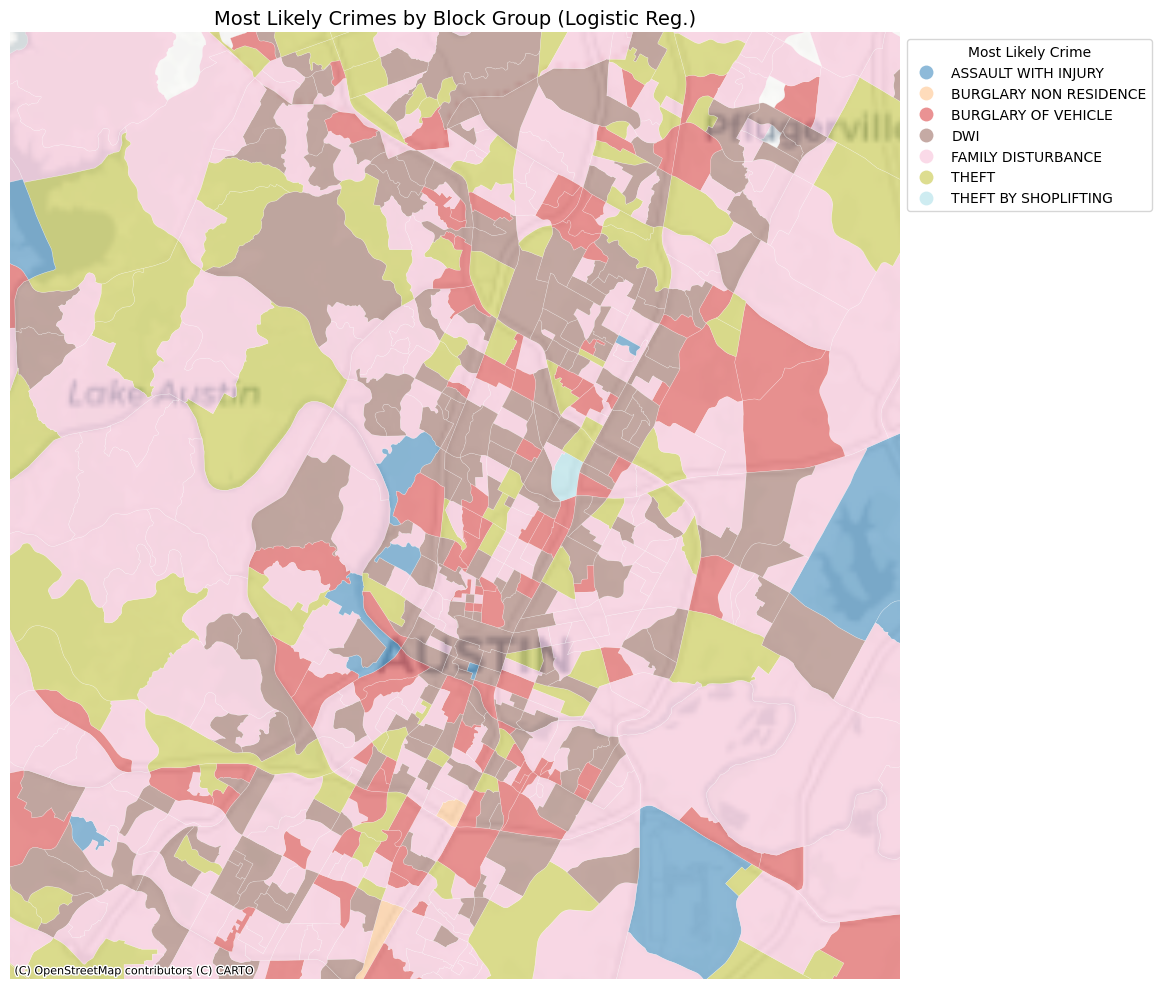

In [30]:
import pandas as pd

results_df = pd.read_csv('../results/crime_log_reg_predictions.csv')
results_df.head()

# 1. Merge predictions with your original polygon data
gdf_results = gdf_polygons.merge(
    results_df[['Census Block Group', 'Top1_Offense']],
    on='Census Block Group'
)
gdf_results.head()

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 2. Create the map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot with categorical colors by top offense
gdf_results.plot(
    column='Top1_Offense',
    ax=ax,
    categorical=True,
    legend=True,
    cmap='tab20',  # Good for 20 categories
    edgecolor='white',
    linewidth=0.3,
    alpha=0.5,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'title': 'Most Likely Crime'
    }
)

# Add basemap
ctx.add_basemap(ax, crs=gdf_results.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set zoom (method 1 or 2 above)
xmin, ymin, xmax, ymax = gdf_results.total_bounds
padding_frac = 0.25  
dx, dy = (xmax-xmin)*padding_frac, (ymax-ymin)*padding_frac
ax.set_xlim(xmin + dx, xmax - dx)
ax.set_ylim(ymin + dy, ymax - dy)

# Final formatting
ax.set_title('Most Likely Crimes by Block Group (Logistic Reg.)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()